# Photon Propagation

This examples shows how to propagate electromagnetic cascades at ultra-high energies.
Note that the `EM*` modules act on photons and electrons only, such that these modules can be used concomitantly with the modules to propagate cosmic-ray nuclei to treat secondary photons produced by cosmic rays.

These simulations can be very time consuming. This particular example shown below can take several minutes to run.

Here we simulate the propagation of UHE protons. We track the electromagnetic cascades initiated by the photons and electrons produced via photopion production. We ignore the electrons produce via Bether-Heitler pair production to make it possible to run the example within a reasonable time.

## Setting up the simulation

In [3]:
from crpropa import *

# file names for output
filename1 = 'primary_protons.txt'
filename2 = 'secondaries_photons.txt'
filename3 = 'secondaries_electrons.txt'

photons = True
neutrinos = False
electrons = True

# background photon fields
cmb = CMB()
ebl = IRB_Gilmore12()
crb = URB_Protheroe96()


# source setup
source = Source()
source.add(SourceParticleType(nucleusId(1, 1)))
source.add(SourcePowerLawSpectrum(10 * EeV, 100 * EeV, -2))
source.add(SourceUniform1D(0, 100 * Mpc))

# setup module list for proton propagation
m = ModuleList()
m.add(SimplePropagation(0, 10 * Mpc))
m.add(MinimumEnergy(1 * EeV))

# observer
obs1 = Observer() # proton output
obs1.add(Observer1D())
obs1.add(ObserverPhotonVeto()) # we don't want photons here
obs1.add(ObserverElectronVeto()) # we don't want electrons
out1 = TextOutput(filename1, Output.Event1D)
out1.setEnergyScale(eV)
out1.enable(Output.WeightColumn)
out1.disable(Output.CandidateTagColumn)
obs1.onDetection(out1)

obs2 = Observer() # photon output
obs2.add(Observer1D())
# obs2.add(ObserverDetectAll()) # stores the photons at creation without propagating them
obs2.add(ObserverElectronVeto())
obs2.add(ObserverNucleusVeto()) # we don't want nuclei here
out2 = TextOutput(filename2, Output.Event1D)
out2.setEnergyScale(eV)

# enables the necessary columns to be compatible with the DINT and EleCa propagation
# out2.enable(Output.CreatedIdColumn) 
# out2.enable(Output.CreatedEnergyColumn)
# out2.enable(Output.CreatedPositionColumn)
out2.enable(Output.WeightColumn)
obs2.onDetection(out2)
out2.disable(Output.CandidateTagColumn)

obs3 = Observer() # electron output
obs3.add(Observer1D())
# obs3.add(ObserverDetectAll()) # stores the photons at creation without propagating them
obs3.add(ObserverPhotonVeto()) # we don't want photons
obs3.add(ObserverNucleusVeto()) # we don't want nuclei here
out3 = TextOutput(filename3, Output.Event1D)
out3.setEnergyScale(eV)
out3.enable(Output.WeightColumn)
out3.disable(Output.CandidateTagColumn)

# enables the necessary columns to be compatible with the DINT and EleCa propagation
# out2.enable(Output.CreatedIdColumn) 
# out2.enable(Output.CreatedEnergyColumn)
# out2.enable(Output.CreatedPositionColumn)
obs3.onDetection(out3)

m.add(obs1)
m.add(obs2)
m.add(obs3)
m.add(ElectronPairProduction(cmb, False)) # secondary electrons are disabled here for this test
m.add(PhotoPionProduction(cmb, photons, neutrinos, electrons)) # enable secondary photons
m.add(EMPairProduction(cmb, electrons))
m.add(EMPairProduction(ebl, electrons))
m.add(EMPairProduction(crb, electrons))
m.add(EMDoublePairProduction(cmb, electrons))
m.add(EMDoublePairProduction(ebl, electrons))
m.add(EMDoublePairProduction(crb, electrons))
m.add(EMInverseComptonScattering(cmb, photons))
m.add(EMInverseComptonScattering(ebl, photons))
m.add(EMInverseComptonScattering(crb, photons))
m.add(EMTripletPairProduction(cmb, electrons))
m.add(EMTripletPairProduction(ebl, electrons))
m.add(EMTripletPairProduction(crb, electrons))

# run simulation
m.run(source, 10000, True)

out1.close()
out2.close()
out3.close()

crpropa::ModuleList: Number of Threads: 8


## Plotting results (optional)

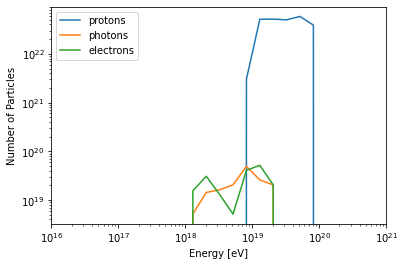

In [4]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt


data1 = np.loadtxt(filename1, dtype = np.float64)
data2 = np.loadtxt(filename2, dtype = np.float64)
data3 = np.loadtxt(filename3, dtype = np.float64)

bins = np.logspace(16, 23, 36, endpoint = True)
x = (bins[1:] - bins[:-1]) / 2. + bins[:-1]

y1, edges = np.histogram(data1[:, 2], bins = bins)
y2, edges = np.histogram(data2[:, 2], bins = bins)
y3, edges = np.histogram(data3[:, 2], bins = bins)

# plot E^2 dN/dE
y1 = y1 * x
y2 = y2 * x
y3 = y3 * x

plt.plot(x, y1, label = 'protons')
plt.plot(x, y2, label = 'photons')
plt.plot(x, y3, label = 'electrons')
plt.xlim(1e16, 1e21)
# ylim(1e2, 1e4)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy [eV]')
plt.ylabel('Number of Particles')
plt.legend()
plt.show()